## Vault pour les secrets, sse-c pour le chiffrement sur S3

Ce tutorial très court vous permet de lire des fichiers chiffrés sur S3.
Nous verrons comment ce tutorial est conçu :
- enregistrement dans vault du secret (variables d'environnement de ce tutorial)
- configuration du driver spark 

Chaque tutorial utilise un contexte d'environnement (variables d'environnement) hébergé dans un "secret" que chaque utilisateur peut lire puisque mis dans le dossier "diffusion". Il y a trois variables : deux qui définissent le projet à cloner et le nom du tutorial.
La troisième étant le secret d'accès au données des tweets de Trump.
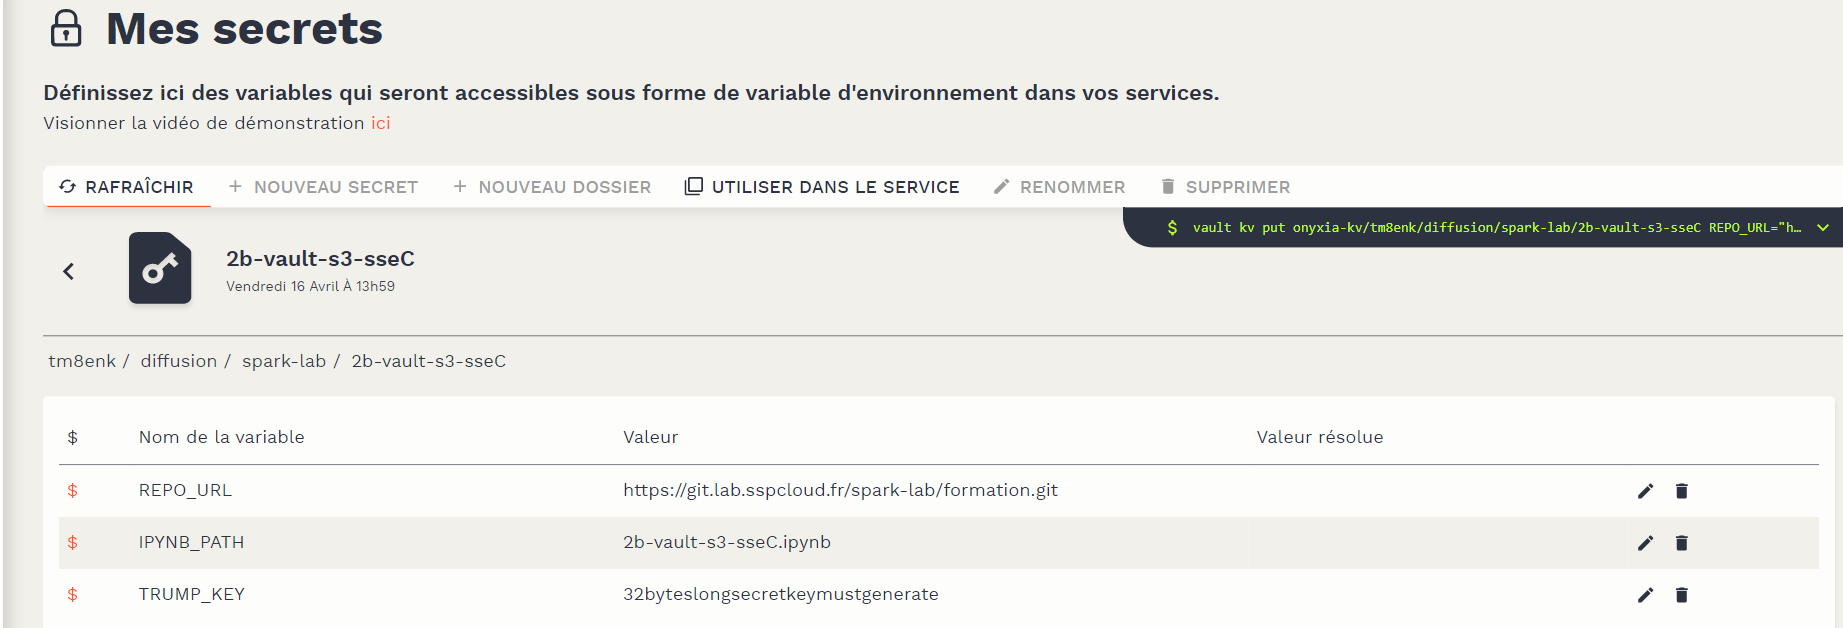

Ce contexte d'environnement est transmis dans l'url du déploiement du tutorial.
Vous constatez que le secret vault à charger est relatif à **tm8enk/diffusion/spark-lab/2b-vault-s3-sseC**
et qu'un script d'init se charge de cloner le projet et de vous placer directement dans le bon notebook.

https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?spark.sparkui=true&kubernetes.role=edit&init.personalInit=https://git.lab.sspcloud.fr/spark-lab/formation/-/raw/master/init-notebook.sh&vault.secret=diffusion/spark-lab/2b-vault-s3-sseC&vault.directory=tm8enk&onyxia.friendlyName=«2b_vault-s3-sseC»

In [1]:
#attention un vrai secret ne devrait jamais être affiché comme je le fais en dessous. Les outputs d'un notebook sont dans le format et donc accessible sur un dépot git.
!echo REPO_URL=$REPO_URL && echo IPYNB_PATH=$IPYNB_PATH && echo TRUMP_KEY=$TRUMP_KEY

REPO_URL=
IPYNB_PATH=
TRUMP_KEY=


### Configuration Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os
import base64
import s3fs
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

#fs.touch('s3://tm8enk/spark-history/.keep')

sparkconf = SparkConf()
sparkconf.setMaster("local[5]")
sparkconf.set("spark.hadoop.fs.s3a.server-side-encryption-algorithm","SSE-C")
sparkconf.set("spark.hadoop.fs.s3a.server-side-encryption.key",base64.b64encode(str.encode(os.environ['TRUMP_KEY'])).decode()) 
sc = SparkContext(conf=sparkconf)




In [3]:
text_file = sc.textFile("s3a://tm8enk/diffusion/tuto/data/trump_insult_tweets_2014_to_2021.csv.ssec")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1] )

counts.take(20)

[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

### Conclusion

Ce tutorial succint vous a montré la possibilité d'externaliser les secrets, d'y accèder comme une variable d'environnement depuis le code.
Le but de ce secret était de déchiffrer les données sur minio et de les monter en mémoire de spark directement.

**Attention les actions de type collect qui ramene une aggrégation des données sur le driver, en l'occurence ici sous le format notebook qu'on commit ensuite sur git peut poser des problèmes de confidentialités.**

Un joli pipeline prend des données chiffrées et peut produire des aggrégats chiffrées sur S3 également.
Les principes de vérification des outputs et du secret statistique restent les mêmes.


In [4]:
sc.stop()